In [1]:
from scipy.integrate import ode, complex_ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm_notebook as tqdm
import time
from scipy.optimize import minimize, approx_fprime, minimize_scalar
from scipy.integrate import odeint, solve_ivp
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [2]:
# Star 1 (Solar Mass SLY4) 1931
# r_R = 1146401.0
# m_R = 2.775310176896487e+33 
# z0 = np.array([(-1.3721907083903563e-07+4.976175027876952e-11j), 
#                (1.5893682319334216e-13-1.2387572639147746e-17j)]) 
# imag = 5.206j

# # Star 2 (Heavy SLY4) 2591
r_R = 1000801.0
m_R = 4.076481530906363e+33
z0 = np.array([(-1.3721919564888775e-07+4.7796264374835803e-11j), 
               (1.5893728465828187e-13-1.1903214173925203e-17j)])
imag = 5.02j

G = 6.67259e-8 # dyne cm2 g-2
c = 2.99792458e10 # cms-1
n_den = 2.3e14
km2cm = 1e5
msun = 1.98847e33
l=2
nl = (l-1)*(l+2)/2
def _b(r, M):
    return (G*M)/((c**2)*r)

In [3]:
def V_z_alt(r, m_R, nl):
    b = _b(r, m_R)
    n = nl
    fac = (1-2*b)
    num = 2*(n**2)*(n+1) + 6*(n**2)*b + 18*n*(b**2) + 18*(b**3)
    dem = (r**2) * (n+3*b)**2
    return fac * num/dem

def r_star_func(r, m_R):
    return r + 2 * (G/(c**2)) * m_R * np.log(abs((r*(c**2))/(2*G*m_R) - 1))

def zerilli_alt(r_star, u, omega):
    z, dZdr_star = u
    m = m_R
    d2Zdr2_star = z * (V_z_alt(r_star, m_R, nl) - omega*np.conj(omega)/(c**2))
    ret = [dZdr_star, d2Zdr2_star] # dZ/dr*, d2Z/dr*2
    return ret 

def alphas(omega, nl, m_R):
    n = nl
    alpha0 = 1 + 1j
    alpha1 = -1j*(n+1)*alpha0*c/omega
    alpha2 = alpha0 * (c**2)*(-n*(n+1)+1j*m_R*omega*(G/(c**3))*(3/2 + 3/n))/(2*omega**2)
    return alpha0, alpha1, alpha2

In [4]:
# # 1983 Version
def r_star_func(r, m_R):
    return r + 2 * (G/(c**2)) * m_R * np.log(abs((r*(c**2))/(2*G*m_R) - 1))

def V_z(r, m_R, nl):
    G_c2 = G/(c**2)
    num = (1-2*G_c2*m_R/r)
    dem = (r**3)*((nl*r+3*G_c2*m_R)**2)
    fac1 = 2*nl**2*(nl+1)*(r**3)
    fac2 = 6*(G_c2**1)*(nl**2)*m_R*(r**2)
    fac3 = 18*(G_c2**2)*nl*(m_R**2)*r
    fac4 = 18*(G_c2**3)*(m_R**3)
    fac = fac1 + fac2 + fac3 + fac4
    ret = fac * num/dem
    return ret

def zerilli(r_star, u, omega):
    omega2 = pow(omega, 2)
    z, dZdr_star = u
    m = m_R
    d2Zdr2_star = z * (V_z(r_star, m_R, nl) - omega2/(c**2))
    ret = [dZdr_star, d2Zdr2_star] # dZ/dr*, d2Z/dr*2
    return ret 

In [5]:
def zrly(omega, r_star_vals, progress = True):
    r = complex_ode(lambda r, VEC: zerilli(r, VEC, omega)).set_integrator('LSODA', atol = 1.49012e-8, rtol = 1.49012e-8)
    r.set_initial_value(z0, r_star_func(r_R, m_R))
    results = [z0]
    r_list = [r_star_func(r_R, m_R)]
    i = 0
    if progress:
        pbar = tqdm(total=len(r_star_vals))
    while r.successful():
        i += 1
        if i >= len(r_star_vals):
            break
        if progress:
            pbar.update(1)
        
        integral = r.integrate(r_star_vals[i])
        if not r.successful():
            break
        results.append(integral)
        r_list.append(r_star_vals[i])
    results = np.array(results, dtype = complex)
    z, dzdr = results.T
    r = np.array(r_list)
    return z, dzdr, r

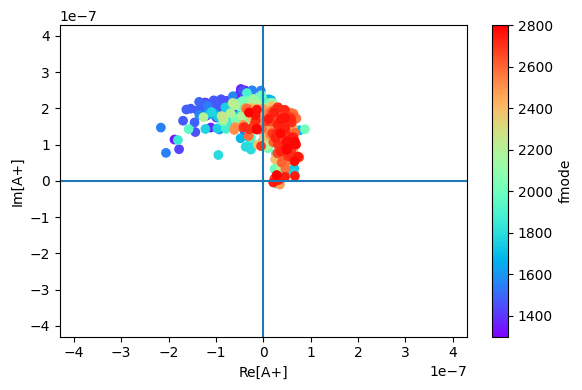

1971.1711711711712
Search Successful!
Fmode = 1971Hz


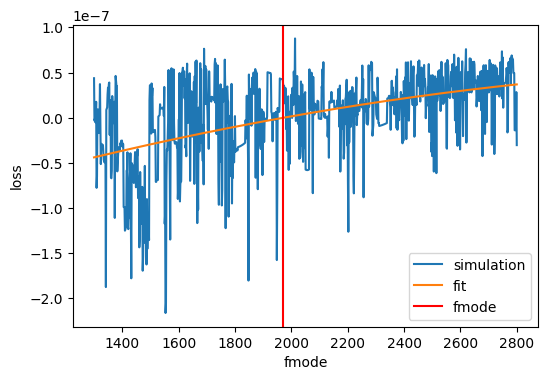

1971.7867449546716 6018.234274965425
1971.1711711711712


In [6]:
# Initial Conditions
omega_vals = []
loss_vals = []
abs_loss_vals = []

fmin = 1300
fmax = 2800
imag = 5.206j

for omega in tqdm(np.linspace(fmin*2*np.pi, fmax*2*np.pi, 1000)):        
    omega = omega + imag
    alpha0, alpha1, alpha2 = alphas(omega, nl, m_R)

    # From surface to inf
    r_vals = np.linspace(r_R, 25 * c / np.real(omega), 500)
    r_star_vals = r_star_func(r_vals, m_R)
    z, dzdr_star, r_int = zrly(omega, r_star_vals, progress = False)

    # Save final values
    zFinal = z[-1]
    zPrimeFinal = dzdr_star[-1]
    rFinal = r_vals[-1]
    rStarFinal = r_star_vals[-1]

    b = _b(rFinal, m_R)

    # Z+/-
    zMinus = np.exp(-1j*(omega/c)*rStarFinal) * (alpha0 + alpha1/rFinal + alpha2/(rFinal**2))
    zPlus = np.conjugate(zMinus)

    # Zprime +/-
    zPrimeMinus = -1j*(omega/c)*np.exp(-1j*(omega/c)*rStarFinal) \
                * (alpha0 + alpha1/rFinal + (alpha2 + 1j*alpha1*(1-2*b)*c/omega)/(rFinal**2))
    zPrimePlus = np.conjugate(zPrimeMinus)

    # A+
    A_plus = -zFinal*zPrimeMinus/(zMinus*zPrimePlus - zPlus*zPrimeMinus) \
            + zMinus*zPrimeFinal/(zMinus*zPrimePlus - zPlus*zPrimeMinus)

    # A-
    A_minus = -zFinal*zPrimePlus/(-zMinus*zPrimePlus + zPlus*zPrimeMinus) \
             + zPlus*zPrimeFinal/(-zMinus*zPrimePlus + zPlus*zPrimeMinus)

    loss = A_plus
    abs_loss = abs(loss)
    omega_vals.append(omega)
    loss_vals.append(loss)
    abs_loss_vals.append(abs_loss)

omega_arr = np.array(omega_vals)
loss_arr = np.array(loss_vals)
abs_loss_arr = np.array(abs_loss_vals)
fmode_arr = np.real(omega_arr/(2*np.pi))

plt.figure(dpi = 100)
sc = plt.scatter(np.real(loss_arr),np.imag(loss_arr), c = 
                 fmode_arr, cmap = cm.rainbow)
plt.xlabel("Re[A+]")
plt.ylabel("Im[A+]")
plt.colorbar(sc, label = "fmode")
plt.tight_layout()
plt.axhline(0)
plt.axvline(0)
lim = 20*min(np.abs(loss_arr))
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

def quadratic(x, a, b, c):
    return a*(x**2)+b*(x)+c


vec = np.real(loss_arr)
popt, pcov = curve_fit(quadratic, xdata = fmode_arr, ydata = vec)
fmode = fmode_arr[np.argmin(np.abs(quadratic(fmode_arr, *popt)))]
print(fmode)


if np.isclose(fmode, min(fmode_arr)) or np.isclose(fmode, max(fmode_arr)):
    print("Search Failed")
else:
    print(f"Search Successful!\nFmode = {round(fmode)}Hz")


plt.figure(dpi = 100)
plt.plot(fmode_arr, vec, label = "simulation")
plt.plot(fmode_arr, quadratic(fmode_arr, *popt), label = "fit")
plt.axvline(fmode, label = "fmode", color = "red")
plt.xlabel("fmode")
plt.ylabel("loss")
plt.legend()
plt.show()

_math_a,_math_b,_math_c = popt
det = np.sqrt(_math_b**2 - 4*_math_a*_math_c)
fmode1 = (-_math_b + det)/(2*_math_a)
fmode2 = (-_math_b - det)/(2*_math_a)
print(fmode1, fmode2)
print(fmode)

fguess = fmode

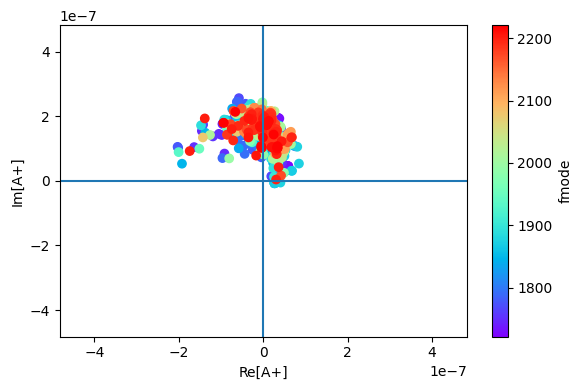

1877.8278278278278
Search Successful!
Fmode = 1878Hz


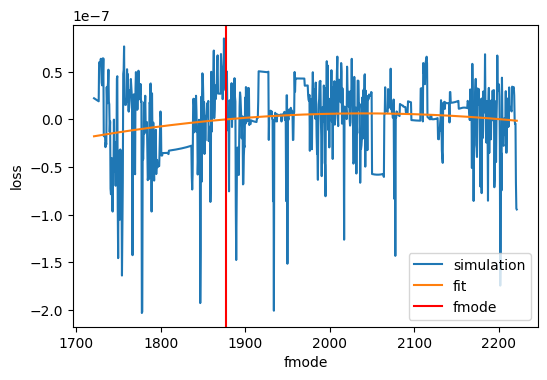

1877.715242901725 2203.271075621337
1877.8278278278278


In [7]:
# Initial Conditions
omega_vals = []
loss_vals = []
abs_loss_vals = []


hw = 250
fmin = fguess-hw
fmax = fguess+hw

for omega in tqdm(np.linspace(fmin*2*np.pi, fmax*2*np.pi, 1000)):        
    omega = omega + imag
    alpha0, alpha1, alpha2 = alphas(omega, nl, m_R)

    # From surface to inf
    r_vals = np.linspace(r_R, 25 * c / np.real(omega), 500)
    r_star_vals = r_star_func(r_vals, m_R)
    z, dzdr_star, r_int = zrly(omega, r_star_vals, progress = False)

    # Save final values
    zFinal = z[-1]
    zPrimeFinal = dzdr_star[-1]
    rFinal = r_vals[-1]
    rStarFinal = r_star_vals[-1]

    b = _b(rFinal, m_R)

    # Z+/-
    zMinus = np.exp(-1j*(omega/c)*rStarFinal) * (alpha0 + alpha1/rFinal + alpha2/(rFinal**2))
    zPlus = np.conjugate(zMinus)

    # Zprime +/-
    zPrimeMinus = -1j*(omega/c)*np.exp(-1j*(omega/c)*rStarFinal) \
                * (alpha0 + alpha1/rFinal + (alpha2 + 1j*alpha1*(1-2*b)*c/omega)/(rFinal**2))
    zPrimePlus = np.conjugate(zPrimeMinus)

    # A+
    A_plus = -zFinal*zPrimeMinus/(zMinus*zPrimePlus - zPlus*zPrimeMinus) \
            + zMinus*zPrimeFinal/(zMinus*zPrimePlus - zPlus*zPrimeMinus)

    # A-
    A_minus = -zFinal*zPrimePlus/(-zMinus*zPrimePlus + zPlus*zPrimeMinus) \
             + zPlus*zPrimeFinal/(-zMinus*zPrimePlus + zPlus*zPrimeMinus)

    loss = A_plus
    abs_loss = abs(loss)
    omega_vals.append(omega)
    loss_vals.append(loss)
    abs_loss_vals.append(abs_loss)

omega_arr = np.array(omega_vals)
loss_arr = np.array(loss_vals)
abs_loss_arr = np.array(abs_loss_vals)
fmode_arr = np.real(omega_arr/(2*np.pi))

plt.figure(dpi = 100)
sc = plt.scatter(np.real(loss_arr),np.imag(loss_arr), c = 
                 fmode_arr, cmap = cm.rainbow)
plt.xlabel("Re[A+]")
plt.ylabel("Im[A+]")
plt.colorbar(sc, label = "fmode")
plt.tight_layout()
plt.axhline(0)
plt.axvline(0)
lim = 20*min(np.abs(loss_arr))
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

def quadratic(x, a, b, c):
    return a*(x**2)+b*(x)+c


vec = np.real(loss_arr)
popt, pcov = curve_fit(quadratic, xdata = fmode_arr, ydata = vec)
fmode = fmode_arr[np.argmin(np.abs(quadratic(fmode_arr, *popt)))]
print(fmode)


if np.isclose(fmode, min(fmode_arr)) or np.isclose(fmode, max(fmode_arr)):
    print("Search Failed")
else:
    print(f"Search Successful!\nFmode = {round(fmode)}Hz")


plt.figure(dpi = 100)
plt.plot(fmode_arr, vec, label = "simulation")
plt.plot(fmode_arr, quadratic(fmode_arr, *popt), label = "fit")
plt.axvline(fmode, label = "fmode", color = "red")
plt.xlabel("fmode")
plt.ylabel("loss")
plt.legend()
plt.show()

_math_a,_math_b,_math_c = popt
det = np.sqrt(_math_b**2 - 4*_math_a*_math_c)
fmode1 = (-_math_b + det)/(2*_math_a)
fmode2 = (-_math_b - det)/(2*_math_a)
print(fmode1, fmode2)
print(fmode)

fguess = fmode

In [8]:
# # Random stuff which doesnt really make sense
# plt.figure(dpi = 100)
# detrend = abs_loss_arr - quadratic(fmode_arr, *popt)
# plt.plot(fmode_arr, detrend, label = "detrend")
# plt.axvline(f_real, color = "goldenrod", label = "true fmode")
# plt.xlabel("fmode")
# plt.ylabel("abs loss")

# # for possible in fmode_arr[np.where(np.diff(np.sign(detrend)))[0]]:
# #     plt.axvline(possible, label = "optimized fmode", color = "red")
# plt.legend()
# plt.show()

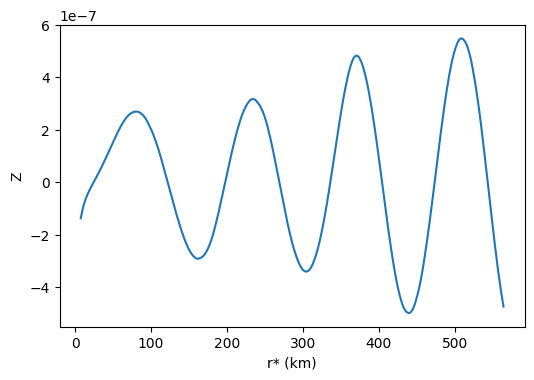

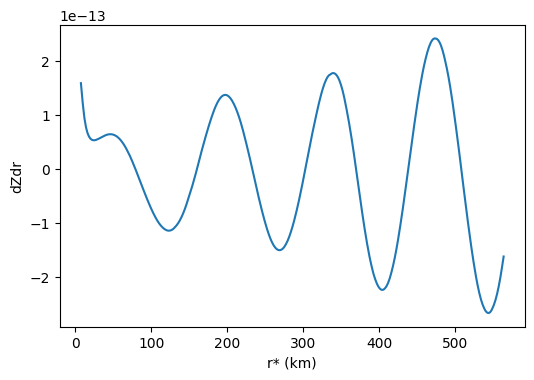

In [9]:
plt.figure(dpi = 100)
plt.plot(r_star_vals/km2cm, np.real(z))
plt.xlabel("r* (km)")
plt.ylabel("Z")
plt.show()

plt.figure(dpi = 100)
plt.plot(r_star_vals/km2cm, np.real(dzdr_star))
plt.xlabel("r* (km)")
plt.ylabel("dZdr")
plt.show()

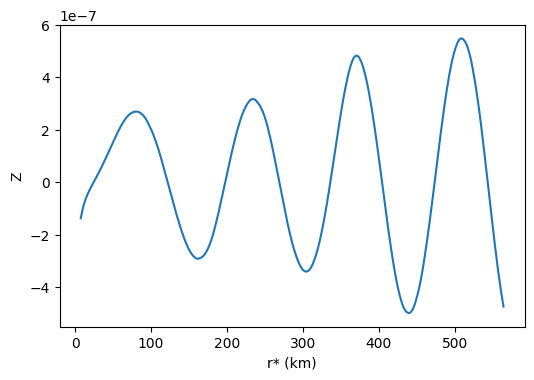

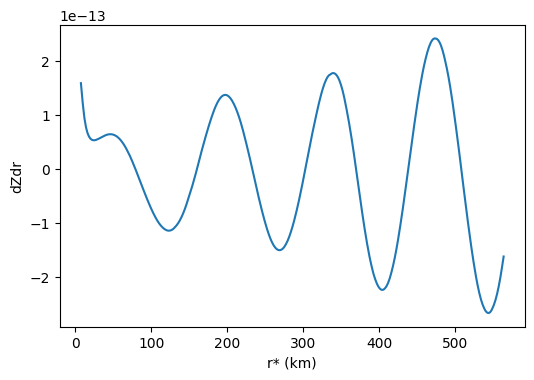

In [10]:
# From surface to inf
r_vals = np.linspace(r_R, 25 * c / np.real(omega), 500)
r_star_vals = r_star_func(r_vals, m_R)

z, dzdr_star, r_int = zrly(omega, r_star_vals, progress = True)

lim = 1

plt.figure(dpi = 100)
plt.plot(r_int/km2cm, np.real(z))
plt.xlabel("r* (km)")
plt.ylabel("Z")
# plt.ylim(-lim, lim)
plt.show()

plt.figure(dpi = 100)
plt.plot(r_int/km2cm, np.real(dzdr_star))
plt.xlabel("r* (km)")
plt.ylabel("dZdr")
# plt.ylim(-lim, lim)
plt.show()

In [11]:
np.isclose(zFinal, z[-1]) # Sanity check that two methods match. 

True

In [12]:
np.isclose(zPrimeFinal, dzdr_star[-1]) # Sanity check that two methods match. 

True